This notebook teaches fine-tuning in transfer learning (un-freeze a few layers that have been imported with transfer learning and make those un-frozen layers train again on our data)

In [ ]:
!nvidia-smi

Mon Nov 15 21:01:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Lets import a bunch of helper functions through a git-hub link
#We could also do the same with our custom code aswell
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-15 21:01:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-15 21:01:01 (79.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import the helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

Now we'll see how to use pre-trained models with tf.keras.applications

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-11-15 21:01:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.251.8.128, 2404:6800:4008:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.8MB/s    in 4.3s    

2021-11-15 21:01:09 (37.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#unzip data using helper functions
unzip_data('10_food_classes_10_percent.zip')

In [ ]:
#Check out how many images and sub-directories are present in our data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
#Use a different data generator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
#check out the class names of our data
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
#See an examples of a batch data
for images, labels in train_data.take(1):
  print (images, labels)

tf.Tensor(
[[[[7.72295914e+01 5.12295914e+01 3.62295914e+01]
   [7.54030609e+01 4.94030609e+01 3.44030609e+01]
   [7.67806168e+01 5.07806129e+01 3.57806129e+01]
   ...
   [2.18642929e+02 2.00642929e+02 1.64214401e+02]
   [2.16403076e+02 1.98403076e+02 1.62403076e+02]
   [2.21086685e+02 2.03086685e+02 1.67086685e+02]]

  [[7.80255127e+01 5.20255089e+01 3.70255089e+01]
   [7.70000000e+01 5.10000000e+01 3.60000000e+01]
   [7.68163223e+01 5.08163261e+01 3.58163261e+01]
   ...
   [2.20255173e+02 2.02255173e+02 1.64255173e+02]
   [2.16448990e+02 1.98448990e+02 1.62448990e+02]
   [2.21122375e+02 2.03122375e+02 1.67122375e+02]]

  [[7.57193909e+01 5.27193871e+01 3.47193871e+01]
   [7.67857132e+01 5.37857132e+01 3.57857132e+01]
   [7.26632614e+01 4.96632652e+01 3.16632652e+01]
   ...
   [2.18025558e+02 2.00025558e+02 1.61596985e+02]
   [2.10704071e+02 1.92704071e+02 1.54275497e+02]
   [2.10515182e+02 1.92515182e+02 1.54515182e+02]]

  ...

  [[1.58428589e+02 1.44428589e+02 1.07428596e+02]
   [1

Building a transfer learning model using the Keras Functional API

In [ ]:
#Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#Freeze the layers of the above model
base_model.trainable = False

#Create inputs to our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input_layer")

#Normalise the input data if using a model like ResNet50V2
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#Pass the input to the base model
x = base_model(inputs)
print (f'Shape after passing the inputs to the base model : {x.shape}')

#Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print (f'Shape after golbal average pooling layer : {x.shape}')

#Create an output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
print (f'Shape after the final Dense layer : {outputs.shape}')

#Combine the model
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing the inputs to the base model : (None, 7, 7, 1280)
Shape after golbal average pooling layer : (None, 1280)
Shape after the final Dense layer : (None, 10)


In [ ]:
#Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
#Fit the model
history_0 = model_0.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="model_0")])

Saving TensorBoard log files to: transfer_learning/model_0/20211115-210122
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 44s 355ms/step - loss: 1.9739 - accuracy: 0.3480 - val_loss: 1.3896 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - 9s 357ms/step - loss: 1.1992 - accuracy: 0.7200 - val_loss: 0.9327 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 7s 267ms/step - loss: 0.8751 - accuracy: 0.7933 - val_loss: 0.7395 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 9s 355ms/step - loss: 0.7140 - accuracy: 0.8293 - val_loss: 0.6507 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 9s 357ms/step - loss: 0.6160 - accuracy: 0.8600 - val_loss: 0.6111 - val_accuracy: 0.8503


In [ ]:
#Evaluate on the full test dataset
model_0.evaluate(test_data) 

79/79 [==============================] - 11s 134ms/step - loss: 0.6229 - accuracy: 0.8388


[0.6228963732719421, 0.8388000130653381]

In [ ]:
#Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print (layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
#Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
#Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


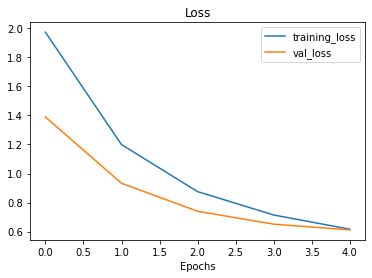

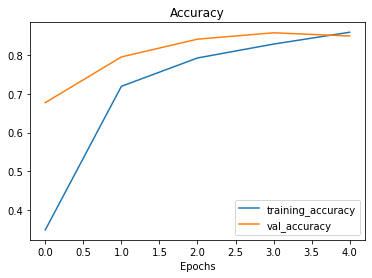

In [ ]:
#Check out the models training curves
plot_loss_curves(history_0)

##Now lets get the second model (Model_1) coded up and ready to train which only trains on 1% of the data with data augmentation

In [ ]:
#Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

#Now unzip data using helper function
unzip_data("10_food_classes_1_percent.zip")

--2021-11-15 21:02:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.251.8.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  53.3MB/s    in 2.4s    

2021-11-15 21:03:02 (53.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
#Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [ ]:
#How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [ ]:
#Set up our data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Adding data augmentation right into the model while building it (horizontal flipping, zooming, etc...)
#Building a data custom augmentation layer
#Adding data augmentation layers as a part of a model is faster as it is implemented on GPU and not the CPU

data_augmentation = tf.keras.models.Sequential([
                                                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name='data_augmentation')

Text(0.5, 1.0, 'Augmented image from class : hamburger')

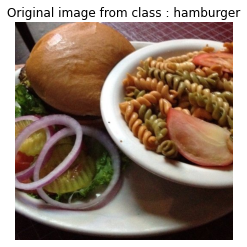

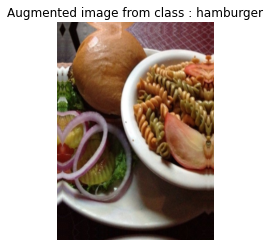

In [ ]:
#Visualize the data augmentation outputs for random image from the dataset
import matplotlib.image as mpimg

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

#Display the random image chosen
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(f'Original image from class : {target_class}')

#Display the augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False)
plt.title(f'Augmented image from class : {target_class}')

In [ ]:
#Now lets build Model_1 (random 1% of training data only)

#Set up input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

#Add in data augmentation layer
x = data_augmentation(inputs)

#Give base model the output of the input layer
x = base_model(x, training=False) 

#Pool output features
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer_2D')(x)

#Add a dense layer on as an output
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

####Now make a model with inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

####Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

####Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data_1_percent,
                        validation_steps=int(0.25*len(test_data_1_percent)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='1_percent_data_aug')])
 

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211115-210308
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 14s 3s/step - loss: 2.4122 - accuracy: 0.1143 - val_loss: 2.2057 - val_accuracy: 0.1661
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1437 - accuracy: 0.2143 - val_loss: 2.0906 - val_accuracy: 0.2401
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9575 - accuracy: 0.3286 - val_loss: 1.9685 - val_accuracy: 0.3553
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7565 - accuracy: 0.6000 - val_loss: 1.8695 - val_accuracy: 0.4211
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5959 - accuracy: 0.7143 - val_loss: 1.8061 - val_accuracy: 0.4753


In [ ]:
#Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r_2D (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [ ]:
#Evaluate on the full test dataset
results_1_percent_data_aug=model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 11s 129ms/step - loss: 1.7892 - accuracy: 0.4772


[1.7892206907272339, 0.4772000014781952]

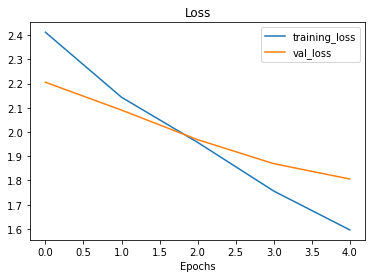

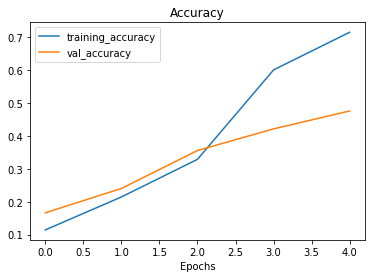

In [ ]:
#Lets look at the loss curves
plot_loss_curves(history_1)

##Now lets get the third model (Model_2) coded up and ready to train which trains on 10% of the data with data augmentation with ModelCheckpointCallback

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [ ]:
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Create a data augmentation layer
data_augmentation = tf.keras.models.Sequential([
                                                tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                                tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
], name='data_augmentation')

#Setup the input shape to our model
input_shape=(224,224,3)

#Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create the inputs and outputs
inputs = tf.keras.layers.Input(shape=input_shape, name='Input_Layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='Global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

####Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
###Creating a ModelCheckpointCallback

#Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

#create a ModelCheckpoint callback that saves the models weights only
checkpoint_calback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_freq='epoch',
                                                        save_best_only=False,
                                                        verbose=1)

In [ ]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[checkpoint_calback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0597 - accuracy: 0.3160
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 672ms/step - loss: 2.0597 - accuracy: 0.3160 - val_loss: 1.5425 - val_accuracy: 0.6332
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4173 - accuracy: 0.6320
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 608ms/step - loss: 1.4173 - accuracy: 0.6320 - val_loss: 1.1173 - val_accuracy: 0.7385
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0929 - accuracy: 0.7200
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 572ms/step - loss: 1.0929 - accuracy: 0.7200 - val_loss: 0.8822 - val_accuracy: 0.7878
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9217 - 

In [ ]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 130ms/step - loss: 0.7162 - accuracy: 0.8124


[0.7162114977836609, 0.8123999834060669]

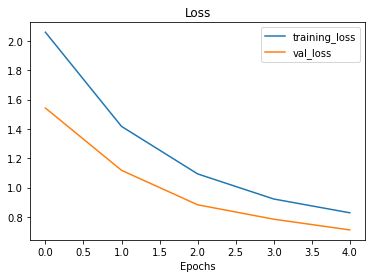

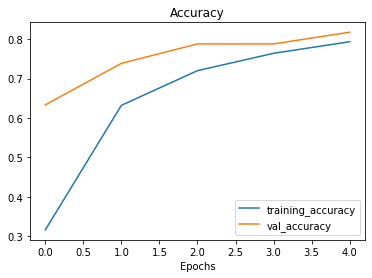

In [ ]:
plot_loss_curves(history_2)

###Load in the weights using the checkpoint created in model_2

In [ ]:
#Load in saved model weights and evaluate the model

model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model_2 with loaded weights

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.7162 - accuracy: 0.8124


###Introduction to fine-tuning a model on 10% training data (Basically unfreezing the top 10 layers of transfer learning model to learn during training)

####Fine tuning actually works better after training the network with custom data for a few epochs

In [ ]:
model_2.layers

In [ ]:
#Are the layers trainable
for layer in model_2.layers:
  print (layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f50d51a7a10> True
<keras.engine.sequential.Sequential object at 0x7f50d51a7c10> True
<keras.engine.functional.Functional object at 0x7f50d4c98190> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f50d4ceeb90> True
<keras.layers.core.dense.Dense object at 0x7f50d4d715d0> True


In [ ]:
#What layers are in our base model
for i, layer in enumerate(model_2.layers[2].layers):
  print (i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
#To begin fine-tuning, lets start by setting the last 10 layers of our base model to trainable=True
base_model.trainable = True

#Freeze all the layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

#We have to recompile the whole model_2 now for fine-tuning to work
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #Lower the learning rate by 10x
                metrics=['accuracy'])

In [ ]:
#Now what layers are in our base model
for i, layer in enumerate(model_2.layers[2].layers):
  print (i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
#Now how many trainable variables are there
print (len(model_2.trainable_variables))

12


In [ ]:
#Lets fine-tune for another five epochs now. Hence re-fit model_2
history_3 = model_2.fit(train_data_10_percent,
                        epochs=10,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1], #So start trining from the previous last epoch
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name='10_percent_fine_tune_last_10_layers')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20211115-215555
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 24s 645ms/step - loss: 0.6964 - accuracy: 0.7947 - val_loss: 0.5553 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 13s 529ms/step - loss: 0.5878 - accuracy: 0.8240 - val_loss: 0.5281 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - 12s 489ms/step - loss: 0.5267 - accuracy: 0.8293 - val_loss: 0.5010 - val_accuracy: 0.8405
Epoch 8/10
24/24 [==============================] - 13s 513ms/step - loss: 0.4859 - accuracy: 0.8613 - val_loss: 0.4884 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 12s 497ms/step - loss: 0.4410 - accuracy: 0.8720 - val_loss: 0.4973 - val_accuracy: 0.8289
Epoch 10/10
24/24 [==============================] - 12s 483ms/step - loss: 0.3903 - accuracy: 0.8733 - val_loss: 0.4568 - val_accuracy: 0.8503


In [ ]:
#Evaluate the fine-tuned model
model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.4935 - accuracy: 0.8400


[0.49353519082069397, 0.8399999737739563]

In [ ]:
#Lets create a function to compare histories
def compare_histories(original_history, new_history, initial_epochs=5):
  #Get original history
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  #Combine original history with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  #Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

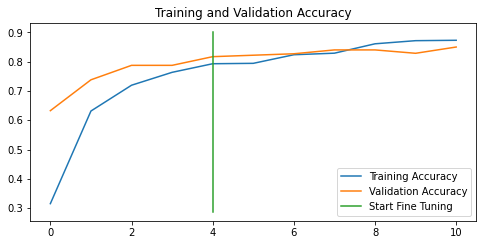

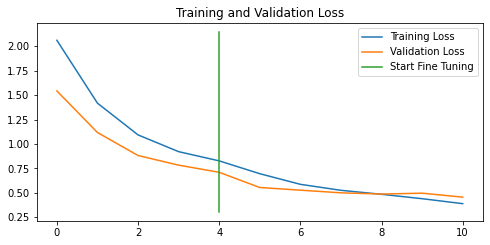

In [ ]:
compare_histories(history_2, history_3, initial_epochs=5)

###Now lets build model_4 with 100% training data (with fine-tuning just like the one with model_3 and the model architecture similar to model_1)

In [ ]:
#Lets download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-11-15 22:20:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  35.0MB/s    in 8.3s    

2021-11-15 22:20:35 (60.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
#Set up train and test dirs
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
#How many images are we working with now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [ ]:
IMG_SIZE=(224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, label_mode='categorical', image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, label_mode='categorical', image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Load the model weights from checkpoint, that way we can fine-tune from the same stage the model_2 was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
#Check which layers in model_2 are tunable
for layer_number, layer in enumerate(model_2.layers):
  print (layer_number, layer.name, layer.trainable)

0 Input_Layer True
1 data_augmentation True
2 efficientnetb0 True
3 Global_average_pooling_layer True
4 output_layer True


In [ ]:
#Compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

In [ ]:
#Continue to train and fine-tune the model on 100% training data
history_4 = model_2.fit(train_data,
                        epochs = 10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='full_10_classes_fine_tune_100_percent_data')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_100_percent_data/20211115-224413
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 92s 358ms/step - loss: 0.7297 - accuracy: 0.7665 - val_loss: 0.4448 - val_accuracy: 0.8553
Epoch 6/10
235/235 [==============================] - 74s 314ms/step - loss: 0.5915 - accuracy: 0.8089 - val_loss: 0.4109 - val_accuracy: 0.8635
Epoch 7/10
235/235 [==============================] - 69s 291ms/step - loss: 0.5275 - accuracy: 0.8288 - val_loss: 0.3667 - val_accuracy: 0.8701
Epoch 8/10
235/235 [==============================] - 65s 273ms/step - loss: 0.4837 - accuracy: 0.8449 - val_loss: 0.3278 - val_accuracy: 0.8914
Epoch 9/10
235/235 [==============================] - 62s 261ms/step - loss: 0.4621 - accuracy: 0.8511 - val_loss: 0.3215 - val_accuracy: 0.8914
Epoch 10/10
235/235 [==============================] - 59s 247ms/step - loss: 0.4258 - accuracy: 0.8629 - val_loss: 0.3392 - val_accuracy: 0.8849


In [ ]:
#Now lets evaluate on all of the test data
model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.3244 - accuracy: 0.8888


[0.32443568110466003, 0.8888000249862671]

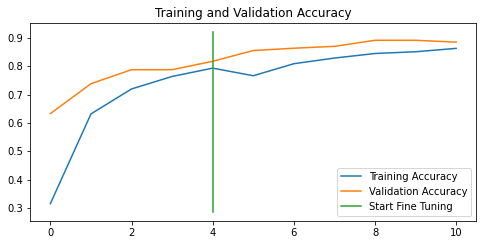

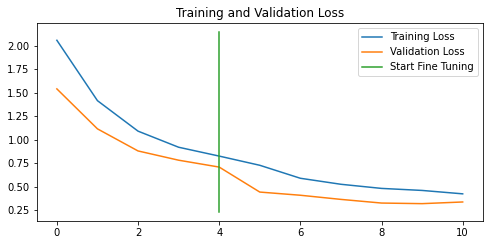

In [ ]:
compare_histories(history_2, history_4, initial_epochs=5)

###Now lets view all our experiments on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments On 10 Food101 Classes" \
  --description "A series of transfer learning experiments" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=hGErr6snkgCWcsXwSAUsIIuBgtNaUm&prompt=consent&access_type=o

In [ ]:
#Now lets delete the created Tensorboard experiments comparison link (because this is public)
!tensorboard dev list

https://tensorboard.dev/experiment/vOWGeeknRfaQqr05K1so3w/
	Name                 Transfer Learning Experiments On 10 Food101 Classes
	Description          A series of transfer learning experiments
	Id                   vOWGeeknRfaQqr05K1so3w
	Created              2021-11-15 23:16:44 (7 minutes ago)
	Updated              2021-11-15 23:16:51 (7 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  3313198
https://tensorboard.dev/experiment/NqfNTz5TRByQtL4mpoJnoA/
	Name                 EffecientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models
	Id                   NqfNTz5TRByQtL4mpoJnoA
	Created              2021-11-10 21:25:31
	Updated              2021-11-10 21:25:34
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3138469
Total: 2 experiment(s)


In [ ]:
#Delete using IDs
!tensorboard dev delete --experiment_id vOWGeeknRfaQqr05K1so3w
!tensorboard dev delete --experiment_id NqfNTz5TRByQtL4mpoJnoA

Deleted experiment vOWGeeknRfaQqr05K1so3w.
Deleted experiment NqfNTz5TRByQtL4mpoJnoA.
